In [1]:
# To keep track of the machine this script is run in
import IPython; import sklearn, numpy as np, scipy; from ast import literal_eval
import platform;

CURR_IPYTHON_VERSION = IPython.__version__
PYTHON_INPT = literal_eval(IPython.sys_info())['sys_executable']
SKVERSION = sklearn.__version__; SCVERSION = scipy.__version__; NPVERSION = np.__version__
print("Running on %s" % platform.platform())
!echo -e "At host \"$(hostname)\" with $(nproc) cores. Current Dir - $(pwd)\n"
!echo -n "sklearn $SKVERSION "
print("@ %s\n" % str(sklearn.__path__))
!echo -e -n "np v$NPVERSION - scipy v$SCVERSION \nIPython v$CURR_IPYTHON_VERSION - "
!echo -n "$($PYTHON_INPT --version)"
!echo "@ $PYTHON_INPT"

Running on Linux-3.19.0-56-generic-x86_64-with-debian-jessie-sid
-e At host "caprica" with 4 cores. Current Dir - /home/zloten/Documents/sklearn-notebook/mixture

sklearn 0.18.dev0 @ ['/home/zloten/Documents/scikit-learn/sklearn']

-e -n np v1.10.4 - scipy v0.17.0 
IPython v4.1.1 - 
Python 3.5.1 :: Continuum Analytics, Inc.
@ /home/zloten/anaconda3/envs/sklearn/bin/python


In [2]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets.samples_generator import make_blobs, make_spd_matrix
from sklearn.mixture import GMM, GaussianMixture

colors = ['c', 'm', 'y', 'k', 'r', 'g', 'b', 'y', 'navy', 'turquoise', 'darkorange']

def covariances_(estimator):
    return estimator.covars_ if isinstance(estimator, GMM) else estimator.covariances_


def generate_data(n_samples, means, covars):
    n_components = len(n_samples)
    X = np.vstack([rng.multivariate_normal(means[j], covars[j], n_samples[j])
                  for j in range(n_components)])
    y = np.concatenate([j * np.ones(n_samples[j])
                       for j in range(n_components)])
    return X, y


def plot_ellipses(means, covars, covariance_type, ax):
    for n in range(means.shape[0]):
        if covariance_type == 'full':
            cov = covars[n][:2, :2]
        elif covariance_type == 'tied':
            cov = covars[:2, :2]
        elif covariance_type == 'diag':
            cov = np.diag(covars[n][:2])
        elif covariance_type == 'spherical':
            cov = np.eye(4) * covars[n]
        v, w = np.linalg.eigh(cov)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2 * np.sqrt(2) * np.sqrt(v)
        if(means.shape[0] > len(colors)):
            ell = mpl.patches.Ellipse(means[n, :2], v[0], v[1], 180 + angle)            
        else:
            ell = mpl.patches.Ellipse(means[n, :2], v[0], v[1], 180 + angle, color=colors[n])
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)


def plot_data(X, y, estimator):
    plt.clf()
    h = plt.subplot(111)
    plt.axis('equal')
    for n, color in enumerate(range(n_components)):
        data = X[y == n]
        
        plt.scatter(data[:, 0], data[:, 1], s=0.8)
        plot_ellipses(estimator.means_, covariances_(estimator),
                      estimator.covariance_type, h)
    plt.draw()  


### Comparison between the old GMM class and the new GaussianMixture class
Some figures comparing the results of the GMM/GaussianMixture classes.

/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, categ

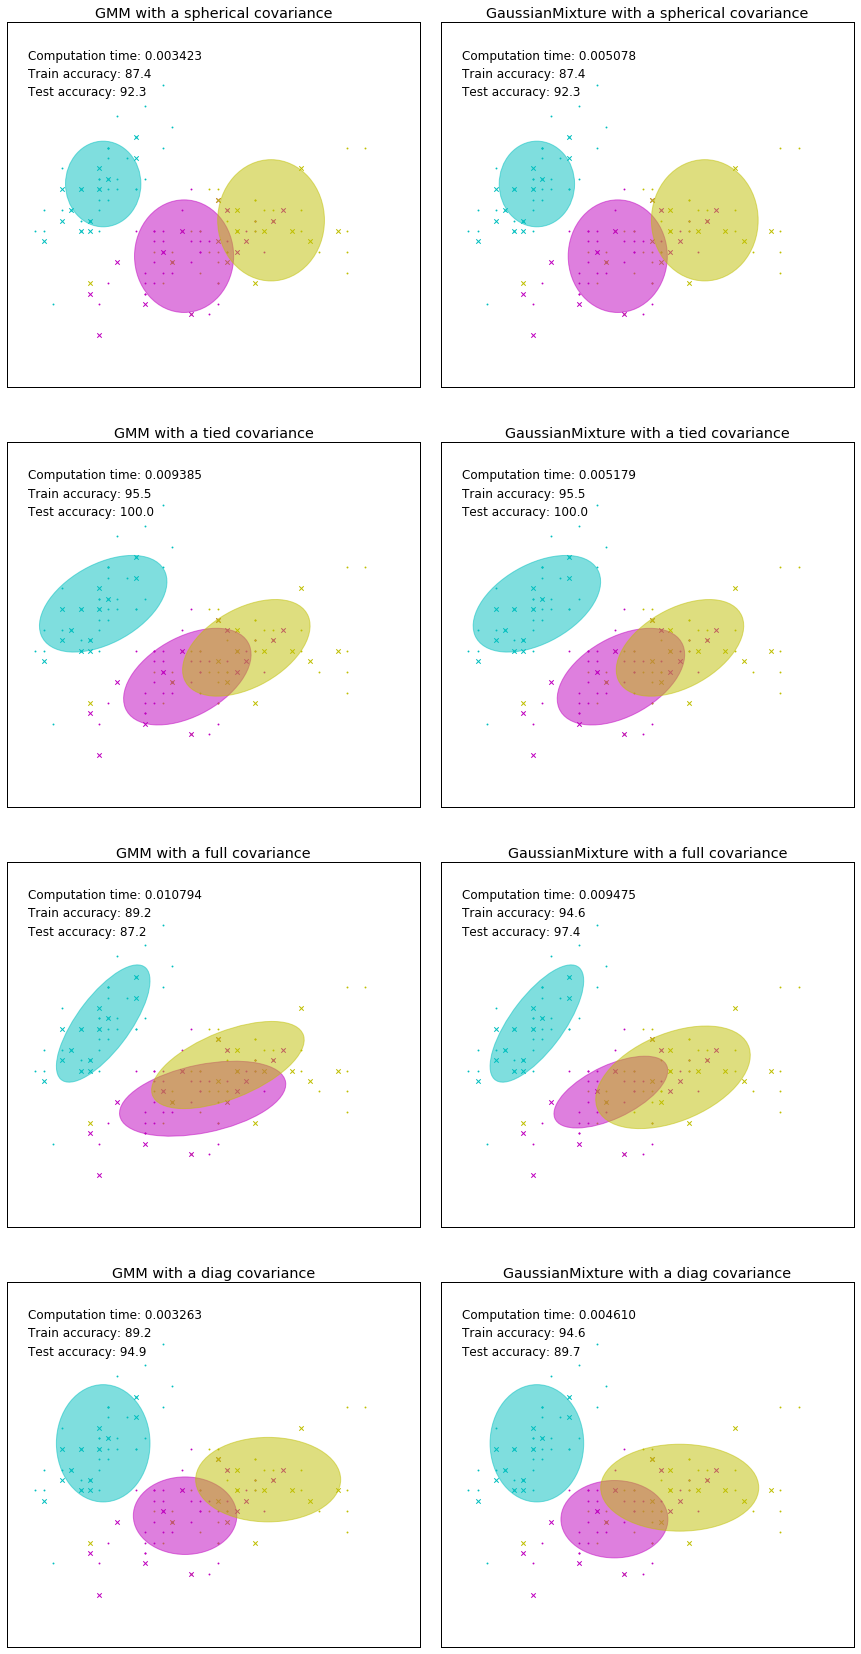

In [3]:
plt.rcParams['figure.figsize'][:] = [12, 12]
plt.rcParams['font.size'] = 12.
plt.rcParams['axes.labelsize'] = 'large'

from time import time
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.externals.six.moves import xrange


def plot_compare(X_train, y_train, X_test, y_test, estimators):
    plt.figure(figsize=(12, 6 * len(estimators)))
    plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                        left=.01, right=.99)

    for index, (name, estimator) in enumerate(estimators.items()):
        estimator[0].means_ = np.array([X_train[y_train == i].mean(axis=0)
                                       for i in xrange(estimator[0].n_components)])
        estimator[1].means_init = np.array([X_train[y_train == i].mean(axis=0)
                                           for i in xrange(estimator[1].n_components)])

        # Train the other parameters using the EM algorithm.
        for k, est in enumerate(estimator):
            computation_time = time()
            est.fit(X_train)
            computation_time = time() - computation_time
            
            h = plt.subplot(len(estimators), 2, k + 2*index + 1)
            plot_ellipses(est.means_, covariances_(est),
                          est.covariance_type, h)
            plt.text(0.05, 0.9, 'Computation time: %f' % computation_time,
                     transform=h.transAxes)
    
            for n in range(est.n_components):
                data = X_train[y_train == n]
                plt.scatter(data[:, 0], data[:, 1], s=0.8, color=colors[n],
                        label=iris.target_names[n])
            # Plot the test data with crosses
            for n in range(est.n_components):
                data = X_test[y_test == n]
                plt.scatter(data[:, 0], data[:, 1], marker='x', color=colors[n])

            y_train_pred = est.predict(X_train)
            train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
            plt.text(0.05, 0.85, 'Train accuracy: %.1f' % train_accuracy,
                     transform=h.transAxes)

            y_test_pred = est.predict(X_test)
            test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
            plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
                     transform=h.transAxes)
    
            plt.xticks(())
            plt.yticks(())
            title = ('GMM ' if k==0 else 'GaussianMixture ') + 'with a '
            plt.title(title + name + ' covariance')


# Import data
iris = datasets.load_iris()
# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))

X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

# Init GMM parameters
n_components = len(np.unique(y_train))
random_state = 0
max_iter = 20
tol = 1e-3
min_covar = 0

estimators = dict((covar_type, 
                   (GMM(n_components=n_components, covariance_type=covar_type,
                   init_params='wc', n_iter=max_iter, min_covar=min_covar,
                   tol=tol / X_train.shape[0], random_state=random_state),
                   GaussianMixture(n_components=n_components, covariance_type=covar_type,
                   max_iter=max_iter, reg_covar=min_covar,
                   tol=tol, random_state=random_state)))
                  for covar_type in ['spherical', 'diag', 'tied', 'full']) 
plot_compare(X_train, y_train, X_test, y_test, estimators)

plt.show()

## Benchmark
### Time efficiency
Here, I present an analysis of the time consumption of the `GaussianMixture` class for different number of samples.

/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, categ

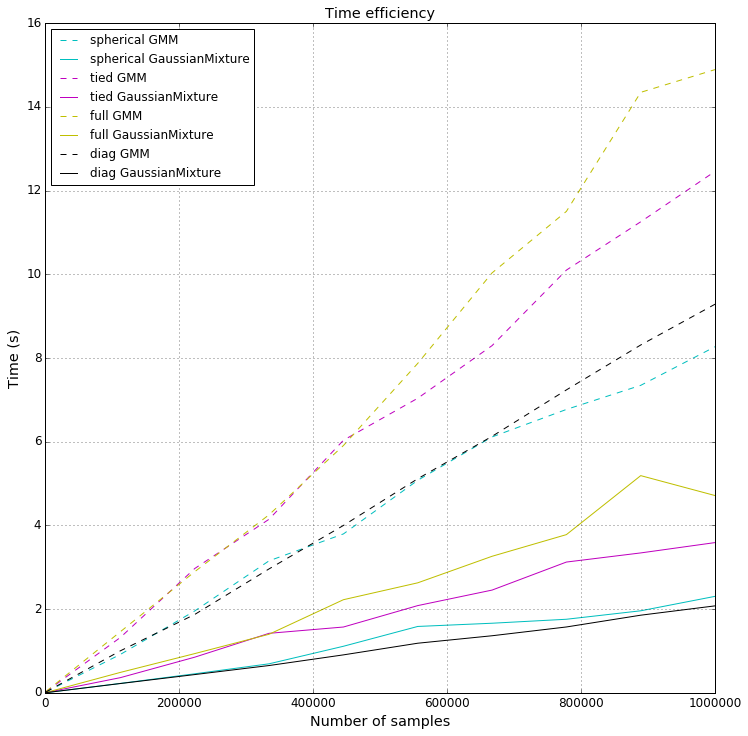

In [4]:
from time import time

random_state = 0
n_components, n_features = 8, 10
max_iter, tol, reg_covar = 100, 1e-3, 0
n_samples_min, n_samples_max, n_samples_iter = 1000, 1e6, 10

rng = np.random.RandomState(random_state)
means = [rng.uniform(-1, 1, n_features) * 30 for _ in range(n_components)]
covars = [make_spd_matrix(n_features, rng) for _ in range(n_components)]
weights = rng.rand(n_components)
weights = weights / np.sum(weights)
n_samples_components = np.round(weights * n_samples_max).astype(int)
X_train, y_train = generate_data(n_samples_components, means, covars)

n_samples_values = np.linspace(n_samples_min, n_samples_max, n_samples_iter)

for n, covariance_type in enumerate({'full', 'tied', 'diag', 'spherical'}):
    time_gaussian_mixture = np.empty(n_samples_iter)
    time_gmm = np.empty(n_samples_iter)
    for k, n_samples in enumerate(n_samples_values):
        n_samples_components = (weights * n_samples).astype(int)
        X = np.vstack([X_train[y_train == j][:n_samples_components[j]]
                       for j in range(n_components)])
        start = time()
        gm = GMM(n_components=n_components, covariance_type=covariance_type,
                 init_params='wmc', n_iter=max_iter, min_covar=reg_covar,
                 tol=tol / X_train.shape[0])
        gm.fit(X)
        time_gmm[k] = time() - start

        start = time()
        gm = GaussianMixture(n_components=n_components,
                             covariance_type=covariance_type, max_iter=max_iter,
                             reg_covar=reg_covar, tol=tol)
        gm.fit(X)
        time_gaussian_mixture[k] = time() - start

    ax = plt.subplot()
    ax.grid(True)
    plt.plot(n_samples_values, time_gmm, '--', color=colors[n],
                 label=covariance_type + ' GMM')
    plt.plot(n_samples_values, time_gaussian_mixture, '-', color=colors[n],
             label=covariance_type + ' GaussianMixture')
    
plt.legend(loc='upper left', prop=dict(size=12))
ax.set_xlabel('Number of samples')
ax.set_ylabel('Time (s)')

plt.title('Time efficiency')
plt.show()

### Memory efficiency

/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zloten/Documents/scikit-learn/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated and will be removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, categ

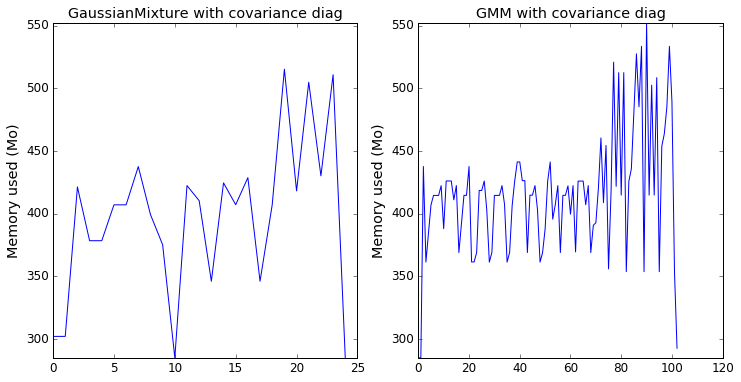

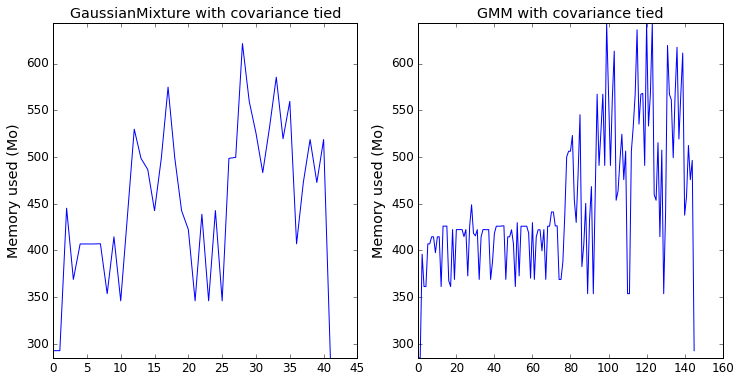

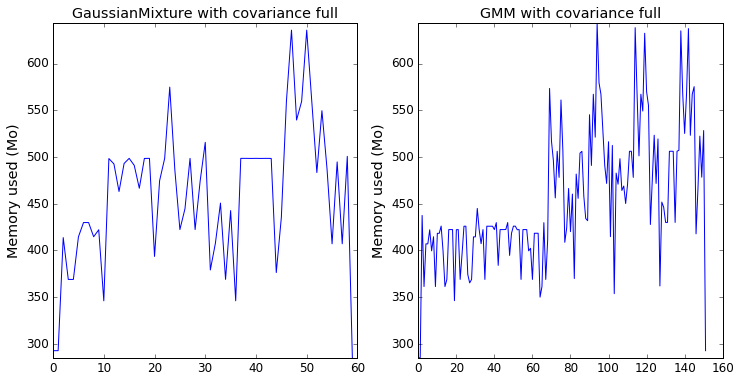

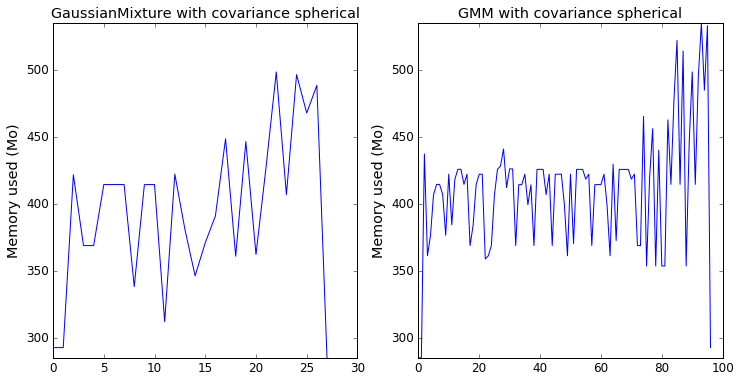

In [35]:
plt.rcParams['figure.figsize'][:] = [12, 6]
plt.rcParams['font.size'] = 12.
plt.rcParams['axes.labelsize'] = 'large'

from memory_profiler import memory_usage


def memory_consumption_Gaussian_Mixture(n_components, covariance_type, max_iter, reg_covar, tol):
    GaussianMixture(n_components=n_components,
                    covariance_type=covariance_type, max_iter=max_iter,
                    reg_covar=reg_covar, tol=tol).fit(X)

    
def memory_consumption_GMM(n_components, covariance_type, max_iter, reg_covar, tol):
    GMM(n_components=n_components, covariance_type=covariance_type,
        init_params='wmc', n_iter=max_iter, min_covar=reg_covar,
        tol=tol / X_train.shape[0]).fit(X)    
    
    
random_state = 0
n_components, n_features = 8, 10
max_iter, tol, reg_covar = 100, 1e-3, 0
n_samples_values = 1e6

rng = np.random.RandomState(random_state)
means = [rng.uniform(-1, 1, n_features) * 30 for _ in range(n_components)]
covars = [make_spd_matrix(n_features, rng) for _ in range(n_components)]
weights = rng.rand(n_components)
weights = weights / np.sum(weights)
n_samples_components = np.round(weights * n_samples_values).astype(int)
X, y = generate_data(n_samples_components, means, covars)

for covariance_type in {'full', 'tied', 'spherical', 'diag'}:
    mem_used_1 = memory_usage((memory_consumption_Gaussian_Mixture, ( 
                    n_components, covariance_type, max_iter, reg_covar, tol) ))
    mem_used_2 = memory_usage((memory_consumption_GMM, ( 
                    n_components, covariance_type, max_iter, reg_covar, tol) ))

    mem_used = np.concatenate((mem_used_1, mem_used_2))
    mem_range = [min(mem_used), max(mem_used)]

    plt.figure()
     
    h1 = plt.subplot(1, 2, 1)    
    h1.plot(mem_used_1)
    h1.set_ylim(mem_range)
    h1.set_ylabel("Memory used (Mo)")
    plt.title("GaussianMixture with covariance %s" % covariance_type)
    
    h2 = plt.subplot(1, 2, 2)
    h2.plot(mem_used_2)
    h2.set_ylim(mem_range)
    h2.set_ylabel("Memory used (Mo)")
    plt.title("GMM with covariance %s" % covariance_type)

plt.show()

### Convergence Analysis

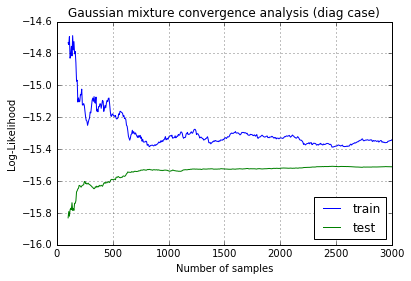

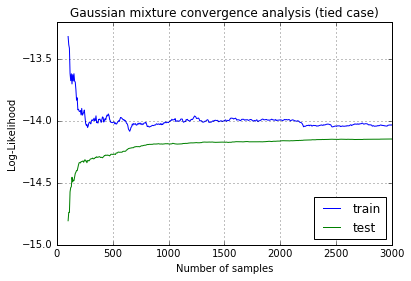

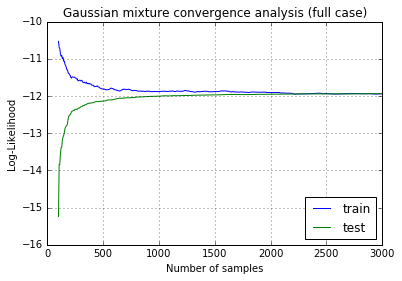

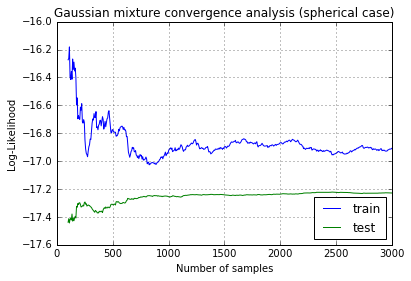

In [8]:
# Init GaussianMixture parameters
random_state = 0
n_components, n_features = 3, 10
max_iter, tol, reg_covar = 200, 1e-6, 0
n_samples = 3000
nb_iter = 500

# Define data
rng = np.random.RandomState(random_state)
means = [rng.uniform(-1, 1, n_features) * 20 for _ in range(n_components)]
covars = [make_spd_matrix(n_features, rng) for _ in range(n_components)]
weights = np.array([0.2, 0.4, 0.4])

n_samples_components = np.round(weights * n_samples).astype(int)
X_test, y_test = generate_data(n_samples_components, means, covars)
X_train, y_train = generate_data(n_samples_components, means, covars)

for covariance_type in {'full', 'tied', 'diag', 'spherical'}:
    # Result computation
    loglikelihood_test = np.empty(nb_iter)
    loglikelihood_train = np.empty(nb_iter)
    for i, n_samples_train in enumerate(np.linspace(100, n_samples, nb_iter)):
        gmm = GaussianMixture(n_components=n_components,
                              covariance_type=covariance_type, max_iter=max_iter,
                              reg_covar=reg_covar, tol=tol,
                              random_state=random_state)
        n_samples_components = (weights * n_samples_train).astype(int)
        X = np.vstack([X_train[y_train == j][:n_samples_components[j]]
                       for j in range(n_components)])
        y = np.concatenate([j * np.ones(n_samples_components[j])
                            for j in range(n_components)])
        gmm.fit(X)

        loglikelihood_train[i] = gmm.score(X)
        loglikelihood_test[i] = gmm.score(X_test)

    # Plot results
    plt.figure()
    plt.title("Gaussian mixture convergence analysis (%s case)" % covariance_type)
    ax = plt.subplot(111)
    plt.plot(np.linspace(100, n_samples, nb_iter),
             loglikelihood_train, label='train')
    plt.plot(np.linspace(100, n_samples, nb_iter),
             loglikelihood_test, label='test')
    plt.legend(loc='lower right', prop=dict(size=12))
    ax.grid(True)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Log-Likelihood')
    
plt.show()

### BIC analysis

I present here analysis of the BIC score for different number of components fitted and for the four covariance type : full, tied, diagonal and spherical.

The result of the fiting of the estimator which minimized the BIC score are presented under the plot.
As we can see, the number of components fitted by the GMM are under the real number of components. 
This can be explain by the proximity of the different cluster. Consequently, the method tends to merge two clusters. This is confirm by the 'full' bic score at `n_component-1` and `n_component` which are close to each other.

/home/zloten/Documents/scikit-learn/sklearn/mixture/base.py:224: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase n_init, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


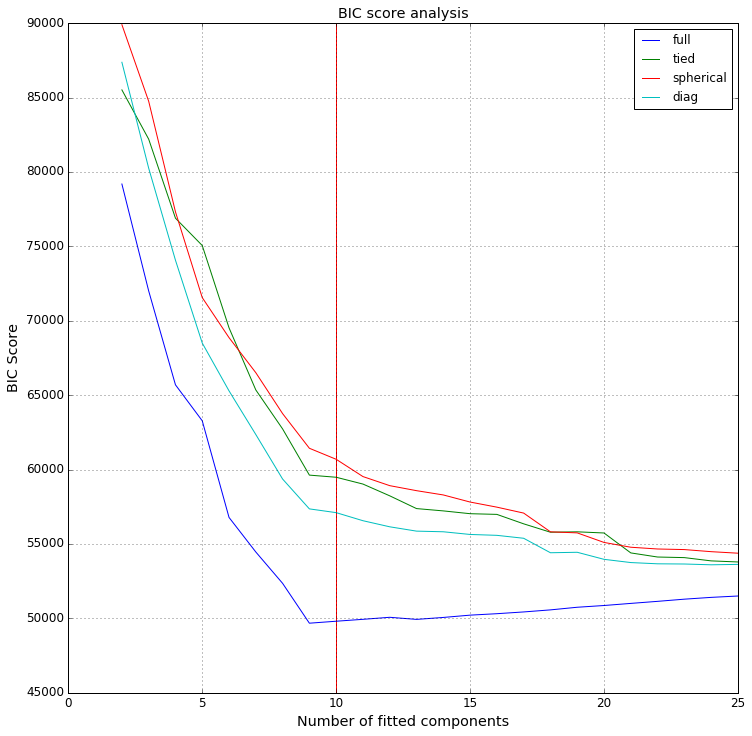

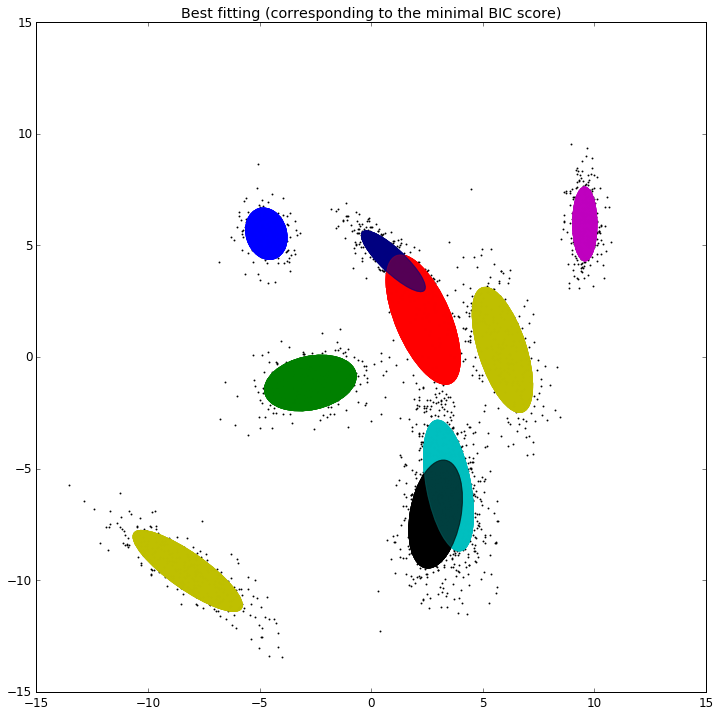

In [36]:
import copy

plt.rcParams['figure.figsize'][:] = [12, 12]
plt.rcParams['font.size'] = 12.
plt.rcParams['axes.labelsize'] = 'large'

# Parameters initialisation
random_state = 0
n_components, n_features = 10, 5
max_iter, tol, reg_covar = 100, 1e-3, 0
n_samples = 3000
n_components_max = 25

rng = np.random.RandomState(random_state)
means = [rng.uniform(-1, 1, n_features) * 10 for _ in range(n_components)]
covars = [make_spd_matrix(n_features, rng) for _ in range(n_components)]
weights = rng.rand(n_components)
weights = weights / np.sum(weights)

n_samples_components = np.round(weights * n_samples).astype(int)
X_train, y_train = generate_data(n_samples_components, means, covars)

nb_iter = n_components_max - 1
log_likelihood_train = np.empty(nb_iter)
bic_train = np.empty(nb_iter)
n_components_iter = np.linspace(2, n_components_max, nb_iter).astype(int)


estimators = dict((covariance_type, GaussianMixture(
                   covariance_type=covariance_type, max_iter=max_iter,
                   reg_covar=reg_covar, tol=tol, random_state=random_state))
                  for covariance_type in ['full', 'tied', 'diag', 'spherical'])

bic_min = np.infty
plt.figure(figsize=(3 * len(estimators), 12))
ax1 = plt.subplot()
ax1.grid(True)
ax1.axvline(x=n_components, color='red')
ax1.set_ylabel("BIC Score")
ax1.set_xlabel("Number of fitted components")

for index, (name, estimator) in enumerate(estimators.items()):
    for i, n in enumerate(np.round(n_components_iter).astype(int)):
        estimator.n_components = n
        estimator.fit(X_train)

        log_likelihood_train[i] = estimator.score(X_train)
        bic_train[i] = estimator.bic(X_train)
        
        if bic_min > bic_train[i]:
            bic_min = bic_train[i]
            best_estimator = copy.copy(estimator)
        
    ax1.plot(n_components_iter, bic_train, '-', label=name)

plt.legend(loc='upper right', prop=dict(size=12))
plt.title('BIC score analysis')
    
plt.figure()
plot_data(X_train, y_train, best_estimator)
plt.title('Best fitting (corresponding to the minimal BIC score)')

plt.show()

### Regularisation analysis

I present here a case where the regularisation of the covariance is necessary to avoid any problem of computation.

The data live in a 10-dimensionnal space and are divided into two clusters. 
The number of samples of second cluster are under the space dimensionnality and the distance between the two clusters are large enough to create a computation problem when we estimate the covariance matrices (case `reg_covar = 0`).

In practice, this case can be seen when the data are corrupted by outliers.
The GMM algorithm can deals with this kind of cases (indeed we can prefer remove these kind of cluster).
Adding `reg_covar * np.diag()` to the covariance allow to ensure that the covariance is positive and avoid all computationnal problems.

/home/zloten/Documents/scikit-learn/sklearn/mixture/base.py:224: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase n_init, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


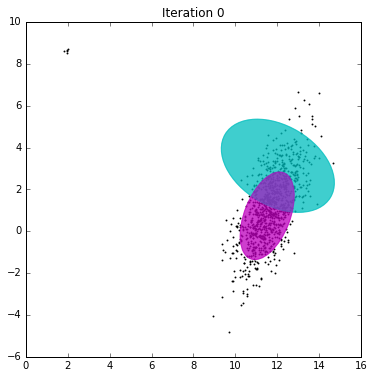

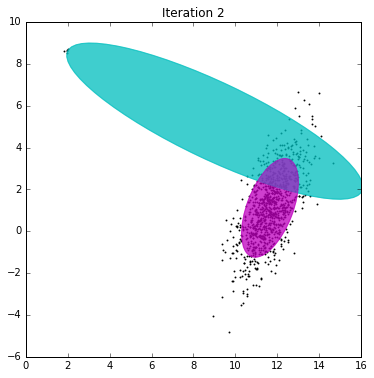

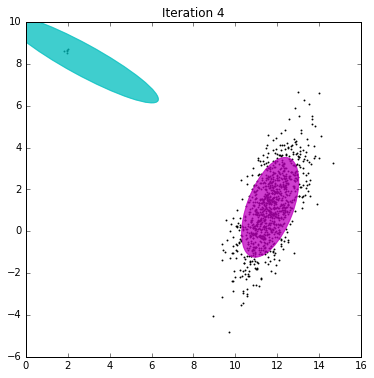

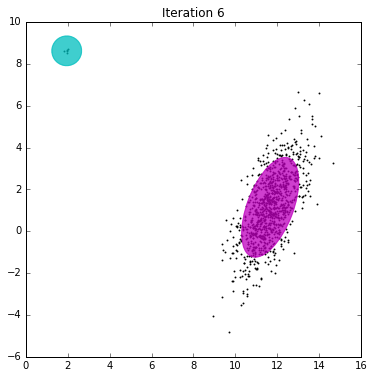

In [38]:
# Parameters initialisation
random_state = 0
covariance_type = 'full'
n_components, n_features, n_samples = 2, 10, 1000
max_iter, tol, reg_covar = 2, 1e-3, .25
n_critical = 5


rng = np.random.RandomState(random_state)
means = [rng.uniform(-1, 1, n_features) * 20 for _ in range(n_components)]
covars = [make_spd_matrix(n_features, rng) for _ in range(n_components)]
covars[0] = 0.01 * np.eye(n_features)
n_samples_components = [n_critical, n_samples - n_critical]
X, y = generate_data(n_samples_components, means, covars)


gm = GaussianMixture(n_components=n_components,
                     covariance_type=covariance_type, max_iter=max_iter,
                     reg_covar=reg_covar, tol=tol, random_state=random_state,
                     warm_start=True)


for k in range(4):
    gm.fit(X)
    plt.figure(figsize=(6, 6))
    h = plt.subplot(111)
    h.axis('equal')
    for n, color in enumerate('rg'):
        data = X[y == n]
        plot_ellipses(gm.means_, gm.covariances_,
                      gm.covariance_type, h)
        h.scatter(data[:, 0], data[:, 1], s=0.8)
    plt.title('Iteration %d' % (2 * k))
    plt.show()
    if gm.converged_:
        break
